<a href="https://colab.research.google.com/github/wandieinnocents/diagnosing_ultrasound_image_DeepLearning/blob/main/submit_chestopacityexam1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>MASTER OF SCIENCE IN COMPUTER SCIENCE</center></h1>
<p><center>DEEP LEARNING , SEMESTER 2 | ASSIGNMENT 1 </center></p>
<p><center><strong> NAME  : WENAREEBA INNOCENT | REG-NO: 2021/HD05/2315U | STUDENT NO : 2100702315</strong></center></p>


<center><h2><b>ULTRA SOUND IMAGE SCAN DEEP LEARNING BASED MODEL</b></h2>

Implementation of a Deep Learning model capable of diagnosing an ultrasound image scan as normal or as having a chest opacity.</center>

In [45]:
# Import libraries
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds
import glob
from google.colab import drive
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras


In [46]:
# tensorflow version
print(tf.__version__)

2.8.2
2.8.2


In [47]:
# mount the google drive to use its resources
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [48]:
# import dataset
import pathlib
# pick the dataset from the drive folder
dataset_one = "/content/drive/MyDrive/deep_learning/dataset1/known_images"
# training dataset
training_dataset = tf.keras.utils.image_dataset_from_directory(dataset_one,validation_split=0.25, subset="training",seed=123,image_size=(100,100),batch_size=20)

Found 715 files belonging to 2 classes.
Using 537 files for training.
Found 715 files belonging to 2 classes.
Using 537 files for training.


In [49]:
# validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset_one, validation_split=0.05,subset="validation",seed=123, image_size=(100,100),batch_size=20)

Found 715 files belonging to 2 classes.
Using 35 files for validation.
Found 715 files belonging to 2 classes.
Using 35 files for validation.


In [50]:
# Testing dataset
testing_dataset = tf.keras.utils.image_dataset_from_directory(dataset_one, validation_split=0.2,subset="validation",seed=123, image_size=(100,100),batch_size=20)

Found 715 files belonging to 2 classes.
Using 143 files for validation.
Found 715 files belonging to 2 classes.
Using 143 files for validation.


In [51]:
# Show class names
display_class_names = training_dataset.class_names
# print class names
print(display_class_names)

['normal', 'sick']
['normal', 'sick']


Visualization of the  the dataset
This shows 12 images from the training dataset

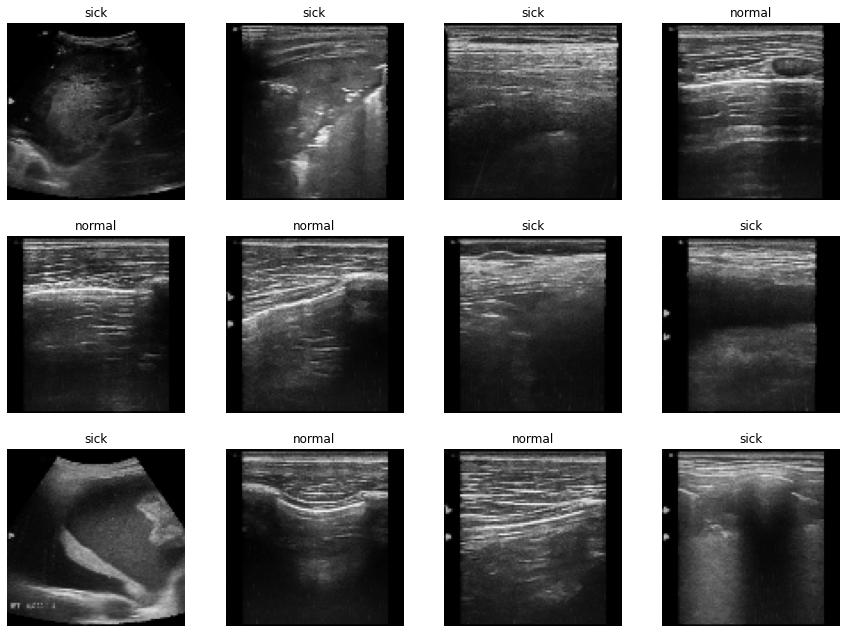

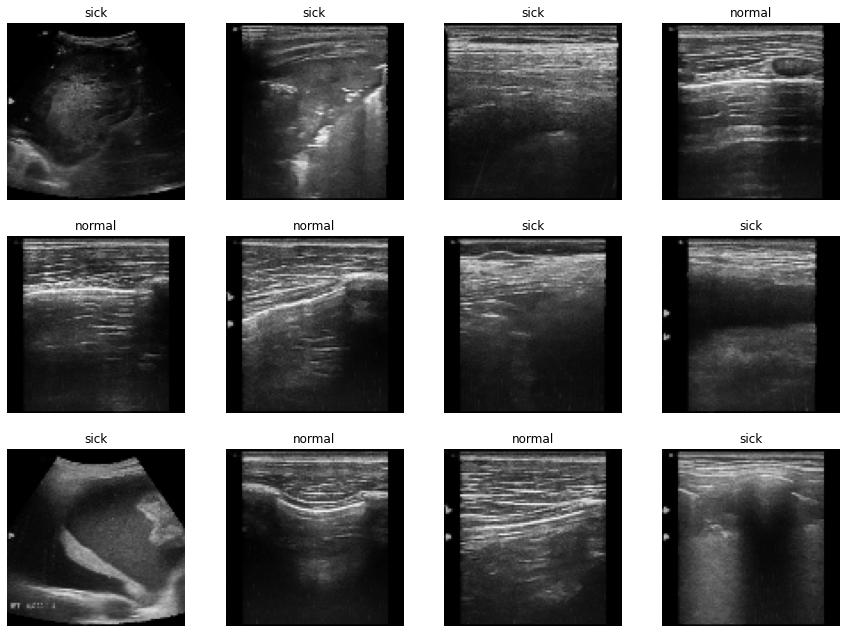

In [52]:
# plot the image datasets
# resize the plot to display
plt.figure(figsize=(15,15))
for images_data,labels in training_dataset.take(1):
  for image in range(12):
    ax = plt.subplot(4,4, image+1)
    plt.imshow(images_data[image].numpy().astype("uint8"))
    plt.title(display_class_names[labels[image]])
    plt.axis("off")

In [53]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(20, 100, 100, 3)
(20,)
(20, 100, 100, 3)
(20,)


Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. 

In [54]:
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)


Standardize the data By normalization

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [55]:
normalization_layer = layers.Rescaling(1./255)


In [56]:
# normalized training dataset
normalized_ds = training_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.8275876
0.0 0.8883726


In [57]:
# normalized validation dataset
normalized_validation_ds = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_validation_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.9750608
0.0 0.9750608


Create the model

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [58]:

from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import regularizers
num_classes = len(display_class_names)

model = Sequential([
layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


Compile the model

using tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model summary

View all the layers of the network using the model's Model.summary method:

In [60]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

Train the model

In [61]:
epochs=10
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)


Epoch 1/10
27/27 [==============================] - 4s 137ms/step - loss: 0.3908 - accuracy: 0.8045 - val_loss: 0.2002 - val_accuracy: 0.9429
Epoch 2/10
27/27 [==============================] - 4s 132ms/step - loss: 0.1819 - accuracy: 0.9292 - val_loss: 0.1357 - val_accuracy: 0.9714
Epoch 3/10
27/27 [==============================] - 4s 132ms/step - loss: 0.1183 - accuracy: 0.9572 - val_loss: 0.1028 - val_accuracy: 0.9714
Epoch 4/10
27/27 [==============================] - 4s 132ms/step - loss: 0.0787 - accuracy: 0.9721 - val_loss: 0.0827 - val_accuracy: 0.9714
Epoch 5/10
27/27 [==============================] - 4s 132ms/step - loss: 0.0392 - accuracy: 0.9888 - val_loss: 0.0715 - val_accuracy: 0.9714
Epoch 6/10
27/27 [==============================] - 4s 133ms/step - loss: 0.0514 - accuracy: 0.9795 - val_loss: 0.1030 - val_accuracy: 0.9429
Epoch 7/10
27/27 [==============================] - 4s 131ms/step - loss: 0.0261 - accuracy: 0.9926 - val_loss: 0.1488 - val_accuracy: 0.9429
Epoch 

Visualize training results
Create plots of loss and accuracy on the training and validation sets:

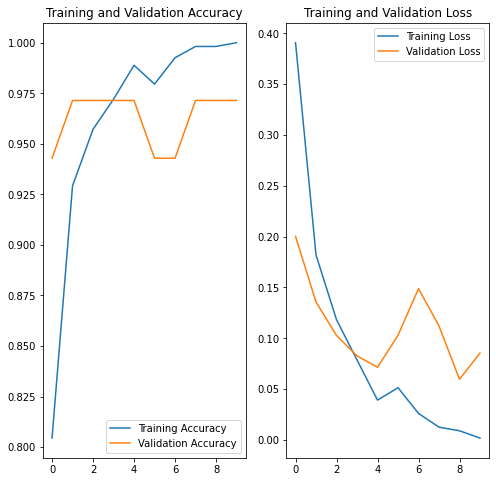

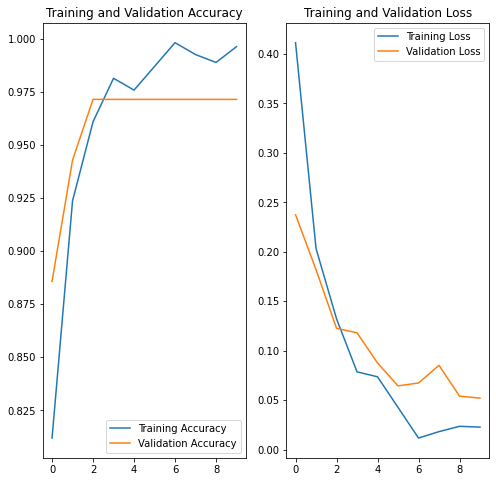

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Overfitting

Incase there is overfitting in outhe model , i was able to rectify it in this stage of the model. since there are a small number of training sets, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples.
I catered for  overfitting in the training process using data augmentation and introducting a dropout.

**Data augmentation to reduce overfitting**

Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. I used it to help me  expose the model to more aspects of the data and generalize better.


In [63]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


**Dropout**

Another technique i used to reduce overfitting was to introduce dropout regularization to the network.

When i  applied  dropout to a layer, it randomly drops out a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1 or 0.2 and this implies dropping out 10% , 20% respectively of the output units randomly from the applied layer. I created the new neural network model with tf.keras.layers.Dropout.

In [64]:
# create second model
from tensorflow.keras.optimizers import Adam

from tensorflow.python.keras import regularizers
num_classes = len(display_class_names)

model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
  layers.Dropout(0.5),
  
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
  layers.Dropout(0.5),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
  layers.Dropout(0.5),

  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
  layers.Dropout(0.5),
  layers.Dense(num_classes)

  # layers.Dense(1,activation='sigmoid')
])

# import Adam
adam = Adam(learning_rate=0.01)


Compile and train the model

In [65]:
# i use adam since it provides more accuracy
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [66]:

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 dropout (Dropout)           (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 32)        0         
                                                      

In [23]:
epochs = 15
history1 = model2.fit(
  # training_dataset,
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)


Epoch 1/15
27/27 [==============================] - 5s 175ms/step - loss: 2.4993 - accuracy: 0.7486 - val_loss: 1.7341 - val_accuracy: 0.9143
Epoch 2/15
27/27 [==============================] - 5s 171ms/step - loss: 1.2574 - accuracy: 0.8901 - val_loss: 1.2595 - val_accuracy: 0.9429
Epoch 3/15
27/27 [==============================] - 5s 171ms/step - loss: 0.9081 - accuracy: 0.9199 - val_loss: 0.9691 - val_accuracy: 0.9429
Epoch 4/15
27/27 [==============================] - 5s 171ms/step - loss: 0.7563 - accuracy: 0.8994 - val_loss: 0.9010 - val_accuracy: 0.9714
Epoch 5/15
27/27 [==============================] - 5s 171ms/step - loss: 0.6107 - accuracy: 0.9404 - val_loss: 0.8546 - val_accuracy: 0.9714
Epoch 6/15
27/27 [==============================] - 5s 170ms/step - loss: 0.5302 - accuracy: 0.9385 - val_loss: 0.7375 - val_accuracy: 0.9714
Epoch 7/15
27/27 [==============================] - 5s 172ms/step - loss: 0.5179 - accuracy: 0.9367 - val_loss: 0.7699 - val_accuracy: 0.9714
Epoch 

Visualize training results

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

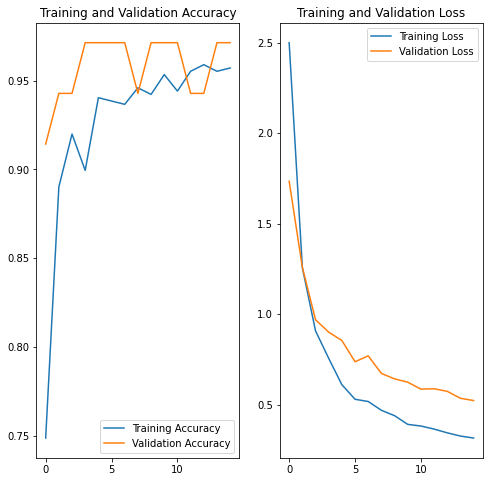

In [24]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**PREDICTING ON KNOWN IMAGES DATASET**

Prediction on Single Normal Image

In [25]:
# prediction on a single normal image
normal_image_1_predictor = "/content/drive/MyDrive/deep_learning/dataset1/known_images/normal/normal_102.png"

img = tf.keras.utils.load_img(normal_image_1_predictor, target_size=(100, 100))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
predictions =model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image is likely to belong to  {} class, with a {:.2f} percent confidence"
    .format(display_class_names[np.argmax(score)], 100*np.max(score))
)

This image is likely to belong to  normal class, with a 100.00 percent confidence


Prediction on Single sick image

In [26]:
# prediction on a single sick image
normal_image_1_predictor = "/content/drive/MyDrive/deep_learning/dataset1/known_images/sick/sick_100.png"

img = tf.keras.utils.load_img(normal_image_1_predictor, target_size=(100, 100))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
predictions =model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image is likely to belong to  {} class, with a {:.2f} percent confidence"
    .format(display_class_names[np.argmax(score)], 100*np.max(score))
)

This image is likely to belong to  sick class, with a 99.60 percent confidence


Prediction on Entire Dataset Known Images

Found 715 files belonging to 2 classes.
Predictions (Known): 
 [1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0]
Labels (Known):
  [1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0]


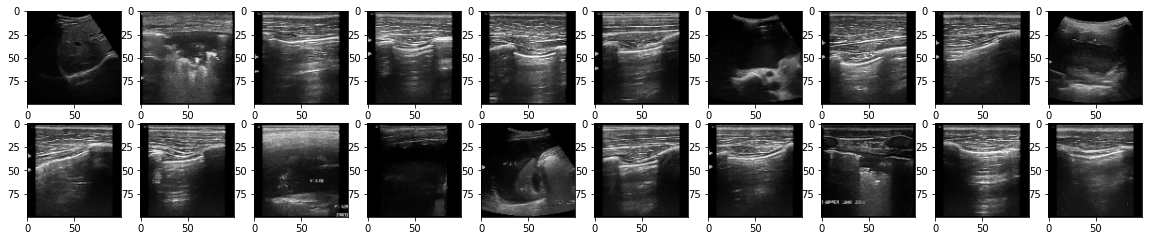

In [27]:
# known_images
dataset_known= "/content/drive/MyDrive/deep_learning/dataset1/known_images"
test_dataset_1 = tf.keras.utils.image_dataset_from_directory(dataset_known, image_size=(100,100),batch_size=20)

image_batch,label_batch = test_dataset_1.as_numpy_iterator().next()
predictions_known_images = model2.predict_on_batch(image_batch)
predictions_known_images = tf.math.argmax(predictions_known_images,1)
print('Predictions (Known): \n',  predictions_known_images.numpy())
print('Labels (Known):\n ', label_batch)

# display the images
plt.figure(figsize=(20,10))
for i in range(20):
    ax = plt.subplot(5,10,i+1)
    plt.imshow(image_batch[i].astype("uint8"))

**EXPORT THE PREDICTIONS TO A CSV**

In [28]:
# Export predictions to csv file
import pandas as pd
import numpy as np
DF_knownimages = pd.DataFrame(predictions_known_images)
DF_knownimages.to_csv("/content/drive/MyDrive/deep_learning/dataset1/known_predictions1.csv")

**CONFUSION MATRIX**

In [29]:
# confusion matrix
y_pred = []
y_true = []

# metrics on the testing dataset for known images
for image_batch, label_batch in testing_dataset:

  y_true.append(label_batch)

  predictions_known_images = model2.predict(image_batch)

  y_pred.append(np.argmax(predictions_known_images, axis = -1))

correct_labels = tf.concat([item for item in y_true],axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis =0)

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm=confusion_matrix(predicted_labels, correct_labels)
print(cm)

[[72  5]
 [ 2 64]]


In [30]:
# plotting
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = display_class_names)

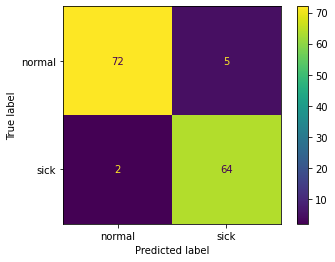

In [31]:
# plot confusion matrix 
disp.plot()

In [32]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(predicted_labels,correct_labels))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        77
           1       0.93      0.97      0.95        66

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



**PREDICT ON UNKNOWN IMAGES DATASET**

Predict on Single unknown image

In [33]:

# Testing single image unknown dataset
dataset_1_image_prediction_unknown = "/content/drive/MyDrive/deep_learning/dataset1/unknown_images/10.png"

img = tf.keras.utils.load_img(dataset_1_image_prediction_unknown, target_size=(100, 100))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
predictions =model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image is likely to belong to  {} class, with a {:.2f} percent confidence"
    .format(display_class_names[np.argmax(score)], 100*np.max(score))
)

This image is likely to belong to  sick class, with a 100.00 percent confidence


Predict on Unknown images dataset 

Found 50 files belonging to 1 classes.
Predictions (UNKnown): 
 [1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 1 1 0 1 1 1 1 1 0 1 1 1]
Labels (UNKnown):
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


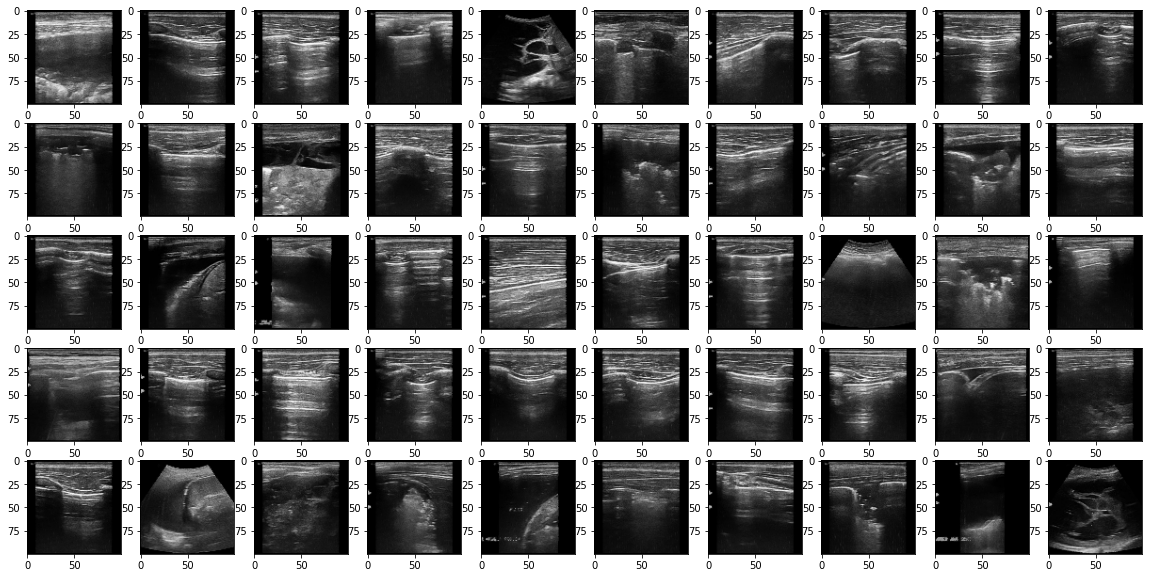

In [34]:
# # unknown_images
dataset_unknown= "/content/drive/MyDrive/deep_learning/unknownimages11"
test_dataset_unknown = tf.keras.utils.image_dataset_from_directory(dataset_unknown, image_size=(100,100),batch_size=50)

image_batch1,label_batch1 = test_dataset_unknown.as_numpy_iterator().next()
predictions_unknown_images = model2.predict_on_batch(image_batch1)
predictions_unknown_images = tf.math.argmax(predictions_unknown_images,1)
print('Predictions (UNKnown): \n',  predictions_unknown_images.numpy())
print('Labels (UNKnown):\n ', label_batch1)

# display the images
plt.figure(figsize=(20,10))
for i in range(50):
    ax = plt.subplot(5,10,i+1)
    plt.imshow(image_batch1[i].astype("uint8"))

In [35]:
# Export unknown predictions to csv file
import pandas as pd
import numpy as np
DF = pd.DataFrame(predictions_unknown_images)
DF.to_csv("/content/drive/MyDrive/deep_learning/dataset1/unknown_predictions.csv")


In [36]:
# confusion matrix unknown
# confusion matrix
y_pred1 = []
y_true1 = []

# metrics on the testing dataset for known images
for image_batch1, label_batch1 in test_dataset_unknown:

  y_true1.append(label_batch1)

  predictions_unknown_images = model.predict(image_batch1)

  y_pred1.append(np.argmax(predictions_unknown_images, axis = -1))

correct_labels1 = tf.concat([item for item in y_true1],axis = 0)
predicted_labels1 = tf.concat([item for item in y_pred1], axis =0)

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm1=confusion_matrix(predicted_labels1, correct_labels1)
print(cm1)

[[24  0]
 [26  0]]


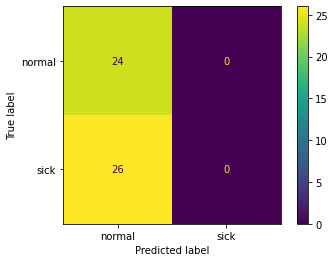

In [37]:
# plotting unknown images
# plotting
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels = display_class_names)
disp1.plot()

In [38]:
# classification report
# classification report
from sklearn.metrics import classification_report
print(classification_report(predicted_labels1,correct_labels1))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        24
           1       0.00      0.00      0.00        26

    accuracy                           0.48        50
   macro avg       0.24      0.50      0.32        50
weighted avg       0.23      0.48      0.31        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**PREDICTING ON DATASET 2**

Images in Dataset2 were captured under different conditions from those in Dataset1 and using a different machine; our intention is to determine how well the model will generalise on images captured under different condition.

Found 224 files belonging to 1 classes.
Predictions: 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
Labels:
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


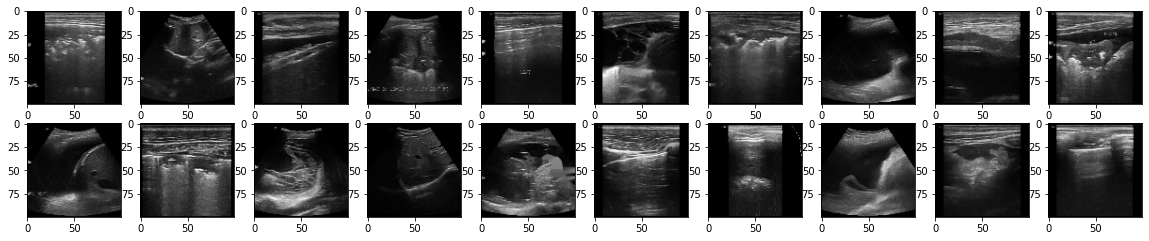

In [39]:

import pandas as pd  
import numpy as np
import csv

# Fetching paths for dataset 2 to print array of images
# Predict data on dataset2 dataset
# Testing Multiple  images  
# dataset_two_path = "/content/drive/MyDrive/deep_learning/dataset2"
dataset_two_path = "/content/drive/MyDrive/deep_learning/dataset22"


test_dataset_2 = tf.keras.utils.image_dataset_from_directory(dataset_two_path, image_size=(100,100),batch_size=20)


image_batch,label_batch = test_dataset_2.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.math.argmax(predictions,1)
print('Predictions: \n', predictions.numpy())
print('Labels:\n ', label_batch)  

plt.figure(figsize=(20,10))
for i in range(20):
    ax = plt.subplot(5,10,i+1)
    plt.imshow(image_batch[i].astype("uint8"))


Export CSV file with predictions of dataset 2 images

In [40]:
# Export predictions to csv file
import pandas as pd
import numpy as np
DF_knownimages = pd.DataFrame(predictions)
DF_knownimages.to_csv("/content/drive/MyDrive/deep_learning/dataset1/dataset_two_final.csv")

CONFUSION MATRIX DATASET 2

In [41]:
# dataset 2 cm
# confusion matrix
y_pred = []
y_true = []

for image_batch, label_batch in test_dataset_2:

  y_true.append(label_batch)

  predictions = model2.predict(image_batch)

  y_pred.append(np.argmax(predictions, axis = -1))

correct_labels = tf.concat([item for item in y_true],axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis =0)

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm=confusion_matrix(predicted_labels, correct_labels)
print(cm)


[[ 21   0]
 [203   0]]


In [42]:
# plotting
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = display_class_names)


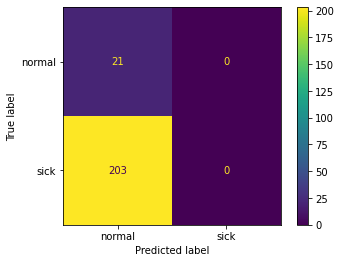

In [43]:
# plot confusion matrix 
# plt.show()
disp.plot()

Classification Report

In [44]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(predicted_labels,correct_labels))

              precision    recall  f1-score   support

           0       0.09      1.00      0.17        21
           1       0.00      0.00      0.00       203

    accuracy                           0.09       224
   macro avg       0.05      0.50      0.09       224
weighted avg       0.01      0.09      0.02       224



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
